# Phenotypic array analyses

In [2]:
# Libraries
library(tidyverse)
library(broom)
library(purrr)
library(car)
library("multcomp")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘TH.data’

The following object is mas

In [3]:
# Read data
data = read.csv("ancetral_all.csv")
well = read.csv("gen_biolog .csv")
well = well[-(1:6),]

## Strain Factor

In [4]:
# t-test
sig = data %>% summarise_each(funs(t.test(.[Strain == "607"], .[Strain == "606"],var.equal=FALSE)$p.value), vars = Well2:Well96)
lol = data %>% dplyr::select(Well2:Well96)
# Rename
names(sig) =colnames(lol)
names(sig) = well$Assay[match(names(sig), well$Well)]
# Transpose
sig_t = sig %>%mutate(Well = "Well") %>% gather(Well) %>% mutate(q_value = p.adjust(value,method='fdr') ) %>%
filter(q_value<0.06) %>% arrange(q_value)
sig_t
write.csv(sig_t, "strain_ancestral_wells.csv")

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

  # Before:
  funs(name = f(.))

  # After: 
  list(name = ~ f(.))
This warning is displayed once per session.”

Well,value,q_value
<chr>,<dbl>,<dbl>
a-D-Lactose,4.130443e-06,0.0001266669
D-Mannitol,2.850277e-06,0.0001266669
D-Galactose,3.912833e-06,0.0001266669
D-Mannose,8.377158e-06,0.0001926746
trehalose,1.518789e-05,0.0002794572
D-Fructose,2.568247e-04,0.0039379790
maltose,3.485672e-04,0.0045811696
D-Melibiose,1.420406e-03,0.0163346633
Niaproof 4,4.893694e-03,0.0500244301


In [508]:
# Homocedastic?
data$Strain = as.factor(data$Strain)
data$Condition = as.factor(data$Condition)
sig_h = data %>% summarise_each(funs(bartlett.test(x=.,g=Strain)$p.value), vars = Well2:Well96)
# Rename
names(sig_h) =colnames(lol)
names(sig_h) = well$Assay[match(names(sig_h), well$Well)]
# Transpose
sig_ht = sig_h %>%mutate(p_val = "p_val") %>% gather(p_val) %>% mutate(fdr = p.adjust(value,method='fdr') ) %>%
filter(fdr<1) %>% arrange(fdr)
sig_ht %>% filter(p_val %in% sig_t$p_val)

p_val,value,fdr
<chr>,<dbl>,<dbl>


# Temperature

In [513]:
# Calculate each t.test
T37_T15 = data %>% summarise_each(funs(t.test(.[Condition == "37"], .[Condition == "15"],var.equal=FALSE)$p.value), vars = Well2:Well96) %>% mutate(contrast = "37_15")
T37_T43 = data %>% summarise_each(funs(t.test(.[Condition == "37"], .[Condition == "43"],var.equal=FALSE)$p.value), vars = Well2:Well96)  %>% mutate(contrast = "37_43")
T15_T43 = data %>% summarise_each(funs(t.test(.[Condition == "15"], .[Condition == "43"],var.equal=FALSE)$p.value), vars = Well2:Well96)  %>% mutate(contrast = "15_43")
all_cont = rbind(T37_T15,T37_T43,T15_T43)
# Rename
names(all_cont) =c(colnames(lol),"contrast")
names(all_cont) = well$Assay[match(names(all_cont), well$Well)]
colnames(all_cont)[93] ="Contrast"
all_cont = all_cont %>% dplyr::select(Contrast, everything())
# Arrange
all_cont_t = gather(all_cont, Assay, p_val, `D-Raffinose`:`Sodium Bromate`)
fdr_corrected = all_cont_t%>% mutate(fdr = p.adjust(p_val,method='fdr') ) %>% arrange(fdr) %>% dplyr::select(-(p_val))
tabular = fdr_corrected %>% spread(Contrast,fdr) %>% arrange(`15_43`)
head(tabular)

Assay,15_43,37_15,37_43
<chr>,<dbl>,<dbl>,<dbl>
dextrin,2.114662e-14,3.513247e-08,2.921141e-11
L-Glutamic Acid,7.281833e-13,3.422456e-10,2.873520e-04
N-Acetyl-β-DMannosamine,7.281833e-13,7.293226e-06,1.615699e-04
L-Alanine,6.990503e-12,1.637183e-10,9.333877e-02
Inosine,1.637183e-10,6.449054e-06,1.168122e-01
Glycyl-L-Proline,2.119586e-10,8.165549e-10,3.710727e-02


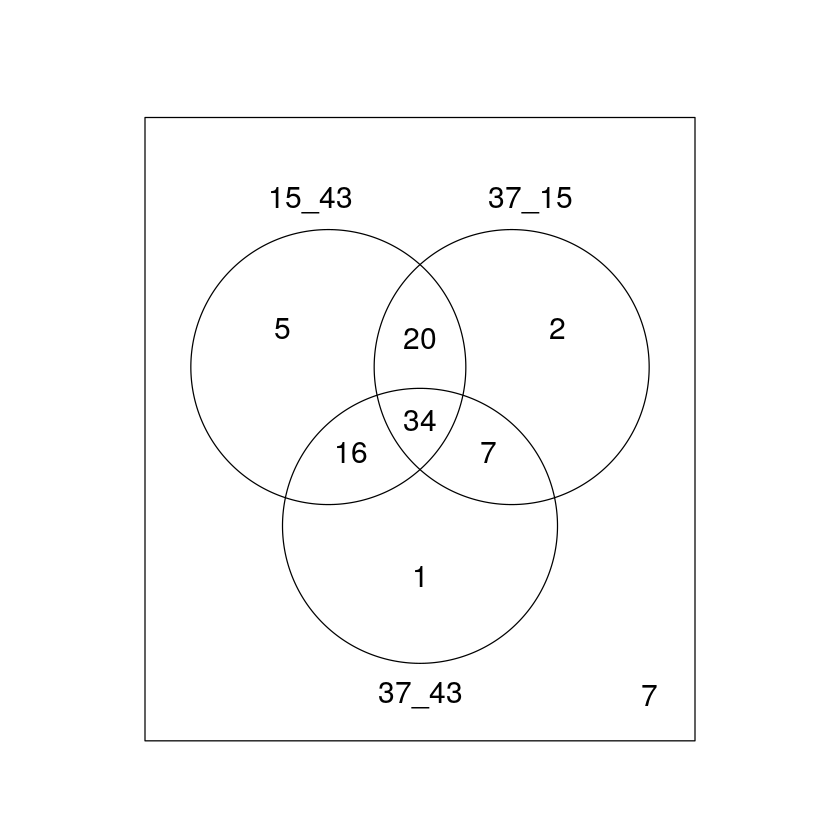

In [514]:
# Venn Diagram
forven = tabular
row.names(forven)=tabular$Assay
forven=forven[,-1]
results = decideTests(forven,adjust.method='none')
vennDiagram(results)

In [524]:
sig_all=results[which(results[,1]!=0 & results[,2]!=0 & results[,3]!=0 ),] #Different in the three
write.csv(sig_all, "ancestral_all_significant.csv")

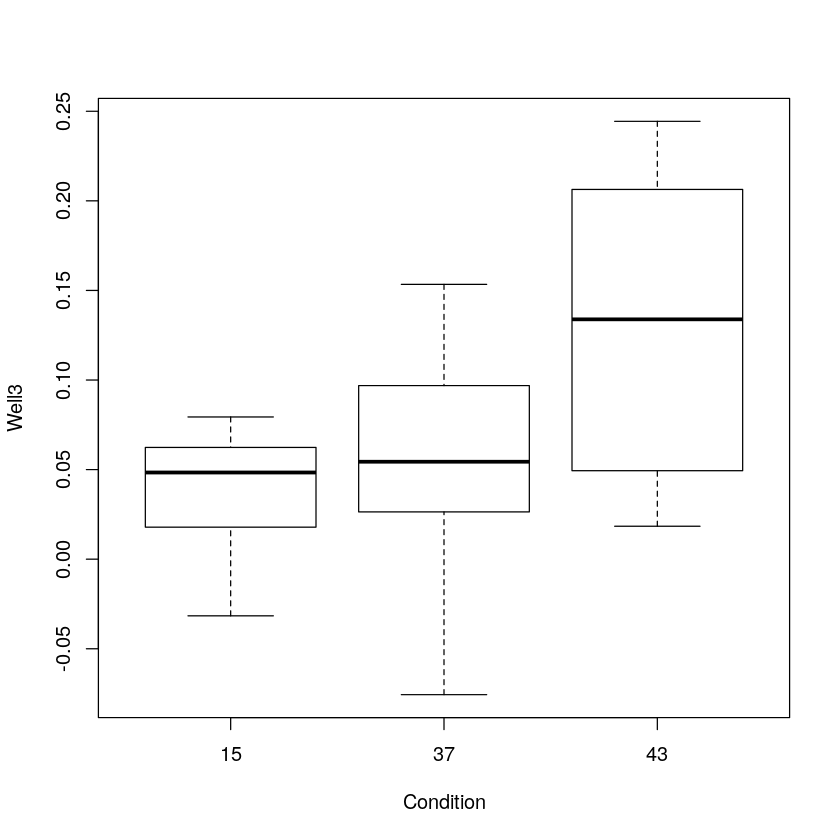

In [522]:
boxplot(Well3~Condition,data)

,15_43,37_15,37_43
dextrin,1,1,1
L-Glutamic Acid,1,1,1
N-Acetyl-β-DMannosamine,1,1,1
Glycyl-L-Proline,1,1,1
L-Rhamnose,1,1,1
D-Saccharic Acid,1,1,1
L-Lactic Acid,1,1,1
L-Malic Acid,1,1,1
L-Aspartic Acid,1,1,1
Glucuronamide,1,1,1


In [501]:
mc38_dif=results[which(results[,1]==0 & results[,2]==1 & results[,3]==1),] #Only different in mc38
mc38_dif

,15_43,37_15,37_43
Minocycline,0,1,1
Lincomycin,0,1,1
D-Fucose,0,1,1
p-HydroxyPhenylacetic Acid,0,1,1
D-Mannitol,0,1,1
a-D-Lactose,0,1,1
maltose,0,1,1
